<a href="https://colab.research.google.com/github/Kprerak-iisc/data-science/blob/master/cyclegan_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


In [ ]:
!ls /content/gdrive/'My Drive/Colab Notebooks'/

cyclegan_1.ipynb  DTLN_norm_40h.h5


In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-hk2l0fu3
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-hk2l0fu3
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=04eb25e45aaecf145503fdf92883454871bf4cfe606805c32ca55391d40da7f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-is9cuycz/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

In [ ]:
data=load('/content/gdrive/My Drive/horse2zebra_128.npz')

Loaded:  (1187, 128, 128, 3) (1474, 128, 128, 3)


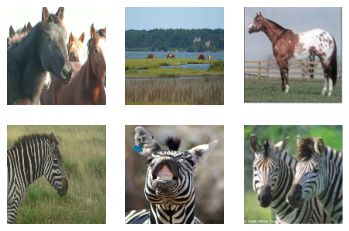

In [ ]:
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(dataA[i].astype('uint8'))
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

In [ ]:
def define_discriminator(image_shape):
    init=RandomNormal(stddev=0.02)
    in_image=Input(shape=image_shape)
    d=Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(in_image)
    d=LeakyReLU(alpha=0.2)(d)
    d=Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
    d=InstanceNormalization(axis=-1)(d)
    d=LeakyReLU(alpha=0.2)(d)
    d=Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
    d=InstanceNormalization(axis=-1)(d)
    d=LeakyReLU(alpha=0.2)(d)
    d=Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
    d=InstanceNormalization(axis=-1)(d)
    d=LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    model=Model(in_image, patch_out)
    model.compile(loss='mse',optimizer=Adam(lr=0.0002,beta_1=0.5),loss_weights=[0.5])
    return model

In [ ]:
image_shape = (128,128,3)
model = define_discriminator(image_shape)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
instance_normalization_1 (In (None, 32, 32, 128)       256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       5245

In [ ]:
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [ ]:
def define_generator(image_shape, n_resnet=6):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [ ]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

In [ ]:
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	#filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save('/content/gdrive/My Drive/g_model_AtoB_%06d.h5' % (step+1))
	# save the second generator model
	#filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save('/content/gdrive/My Drive/g_model_BtoA_%06d.h5' % (step+1))
	print('>Saved: %s and %s' % ('g_model_AtoB_%06d.h5' % (step+1), 'g_model_BtoA_%06d.h5' % (step+1)))

In [ ]:
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	#filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig('/content/gdrive/My Drive/%s_generated_plot_%06d.png' % (name, (step+1)))
	pyplot.close()

In [ ]:
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

In [ ]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 60, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

In [ ]:
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
 

In [ ]:
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/gdrive/My Drive/g_model_AtoB_pretrained.h5', cust,compile=False)
model_BtoA = load_model('/content/gdrive/My Drive/g_model_BtoA_pretrained.h5', cust,compile=False)

In [ ]:
dataset = load_real_samples('/content/gdrive/My Drive/horse2zebra_128.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
#g_model_AtoB = define_generator(image_shape)
g_model_AtoB = model_AtoB
# generator: B -> A
#g_model_BtoA = define_generator(image_shape)
g_model_BtoA = model_BtoA
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (1187, 128, 128, 3) (1474, 128, 128, 3)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
>66223, dA[0.005,0.002] dB[0.001,0.001] g[2.952,2.967]
>66224, dA[0.068,0.004] dB[0.001,0.000] g[2.956,2.909]
>66225, dA[0.006,0.009] dB[0.001,0.001] g[2.435,2.503]
>66226, dA[0.003,0.170] dB[0.002,0.001] g[2.870,2.043]
>66227, dA[0.007,0.022] dB[0.000,0.001] g[2.614,2.704]
>66228, dA[0.183,0.060] dB[0.000,0.001] g[2.379,2.909]
>66229, dA[0.061,0.007] dB[0.001,0.001] g[3.099,3.209]
>66230, dA[0.006,0.006] dB[0.001,0.001] g[2.465,2.467]
>66231, dA[0.004,0.006] dB[0.000,0.000] g[3.837,3.449]
>66232, dA[0.003,0.004] dB[0.001,0.001] g[3.751,3.245]
>66233, dA[0.009,0.002] dB[0.000,0.001] g[2.722,2.964]
>66234, dA[0.010,0.011] dB[0.001,0.001] g[2.277,2.332]
>66235, dA[0.002,0.007] dB[0.000,0.001] g[2.659,2.698]
>66236, dA[0.006,0.009] dB[0.000,0.001] g[2.810,2.585]
>66237, dA[0.003,0.003] dB[0.001,0.001] g[2.547,2.326]
>66238, dA[0.012,0.066] dB[0.001,0.000] g[3.243,3.222]
>66239, dA[0.010,0.004] dB[0.001,0.000] g[2.811,2.938]
>66240, dA[0.0

In [ ]:
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

In [ ]:
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()
 

Loaded (1187, 128, 128, 3) (1474, 128, 128, 3)


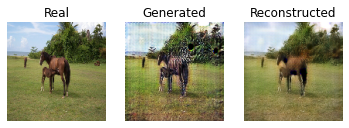

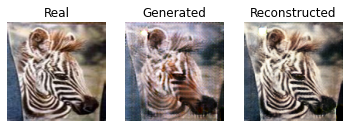

In [ ]:
A_data, B_data = load_real_samples('/content/gdrive/My Drive/horse2zebra_128.npz')
print('Loaded', A_data.shape, B_data.shape)
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/gdrive/My Drive/horse_zebra/g_model_AtoB_035610.h5', cust,compile=False)
model_BtoA = load_model('/content/gdrive/My Drive/horse_zebra/g_model_BtoA_035610.h5', cust,compile=False)
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

In [ ]:
from keras.preprocessing.image import load_img

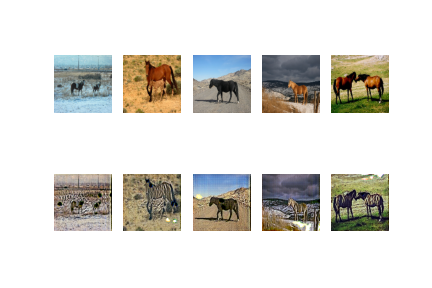

In [ ]:
im=load_img('/content/gdrive/My Drive/AtoB_generated_plot_008309.png')
im

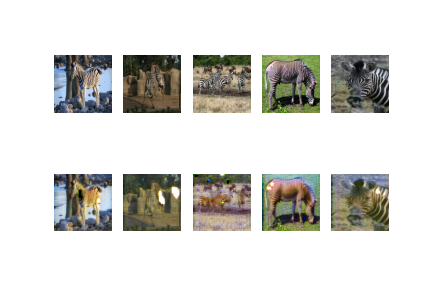

In [ ]:
im=load_img('/content/gdrive/My Drive/BtoA_generated_plot_005935.png')
im

In [ ]:
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import expand_dims
def load_image(filename, size=(128,128)):
	# load and resize the image
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# transform in a sample
	pixels = expand_dims(pixels, 0)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	return pixels

In [ ]:
#image_src = load_image('/content/gdrive/My Drive/horse_zebra/trainA/n02381460_541.jpg')
#image_src = load_image('/content/gdrive/My Drive/horse_zebra/trainA/n02381460_311.jpg')
#image_src = load_image('/content/gdrive/My Drive/horse_zebra/trainA/n02381460_476.jpg')
#image_src = load_image('/content/gdrive/My Drive/horse_zebra/trainA/n02381460_357.jpg')
image_src = load_image('/content/gdrive/My Drive/horse_zebra/trainA/n02381460_591.jpg')



In [ ]:
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/gdrive/My Drive/horse_zebra/g_model_AtoB_029675.h5', cust,compile=False)

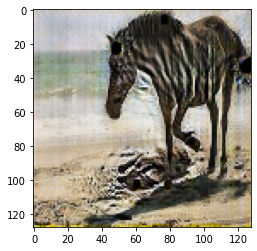

In [ ]:
image_tar = model_AtoB.predict(image_src)
image_tar = (image_tar + 1) / 2.0
# plot the translated image
pyplot.imshow(image_tar[0])
pyplot.show()